**Activate the environment **

`$ source activate catalyst`


**Verify that Catalyst** is install correctly:

`$ catalyst --version`

**To deactivate** an active environment, use:

`$ source deactivate`

**Jupyter Notebook**

อยู่ใน env ของ (catalyst) แล้ว run jupyter notebook จะได้ jupyter notebook ที่มี env ของ catalyst

`(catalyst)$ jupyter notebook`

# Setup

request เพื่อตรวจสอบราคาทุกๆนาที ดังนั้นในวันหนึ่งจะ request 24x60 = 1440 ครั้ง

จะได้ 1,440 ครั้ง/day/เหรียญ

#### Ingesting data

Please remember to ingest the data that you need from the console since that functionality is not supported from within the Notebook. For the example below, you first need to run the following from the CLI:

In [1]:
%%bash
catalyst ingest-exchange -x binance -f minute -i bat_btc

Trying to ingest exchange bundle binance...
Ingesting minute price data on binance


In [2]:
# Register the catalyst magic
%load_ext catalyst

In [3]:
# Setup matplotlib to display graphs inline in this Notebook
%matplotlib inline

[2018-07-14 06:17:15.879382] WARNING: run_algo: Catalyst is currently in ALPHA. It is going through rapid development and it is subject to errors. Please use carefully. We encourage you to report any issue on GitHub: https://github.com/enigmampc/catalyst/issues
[2018-07-14 06:17:15.881842] INFO: run_algo: Catalyst version 0.5.15
[2018-07-14 06:17:18.887711] INFO: run_algo: running algo in backtest mode
[2018-07-14 06:17:18.900876] INFO: exchange_algorithm: initialized trading algorithm in backtest mode
[2018-07-14 06:35:50.272771] INFO: Performance: Simulated 72 trading days out of 72.
[2018-07-14 06:35:50.286880] INFO: Performance: first open: 2018-05-01 00:00:00+00:00
[2018-07-14 06:35:50.289080] INFO: Performance: last close: 2018-07-11 23:59:00+00:00


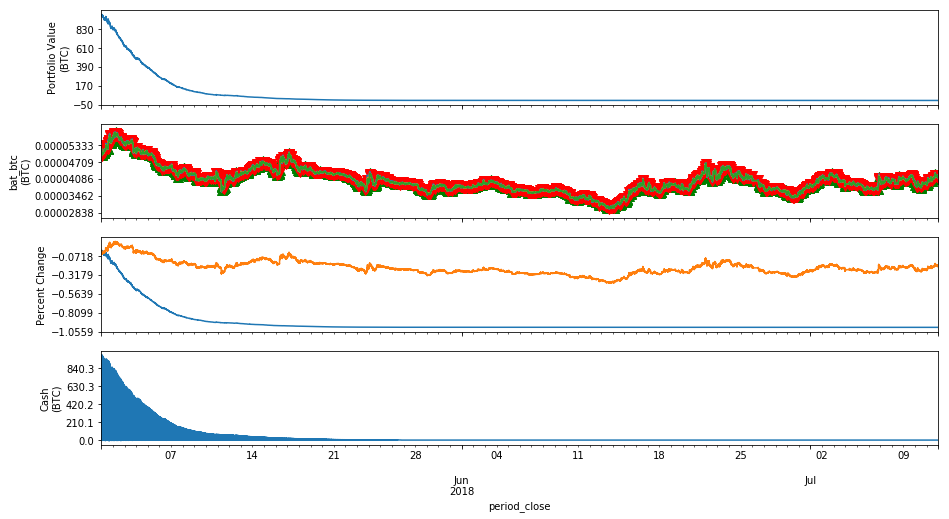

In [6]:
# %%catalyst --start 2018-1-1 --end 2018-7-12 --capital-base 100000 -x binance -c btc --data-frequency minute

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from logbook import Logger

from catalyst import run_algorithm
from catalyst.api import (record, symbol, order_target_percent,)
from catalyst.exchange.utils.stats_utils import extract_transactions

NAMESPACE = 'dual_moving_average'
log = Logger(NAMESPACE)


def initialize(context):
    context.i = 0
    context.asset = symbol('bat_btc')
    context.base_price = None


def handle_data(context, data):
    # define the windows for the moving averages
    short_window = 10
    long_window = 20

    # Skip as many bars as long_window to properly compute the average
    context.i += 1
    if context.i < long_window:
        return

    # Compute moving averages calling data.history() for each
    # moving average with the appropriate parameters. We choose to use
    # minute bars for this simulation -> freq="1m"
    # Returns a pandas dataframe.
    short_data = data.history(context.asset,
                              'price',
                              bar_count=short_window,
                              frequency="1T",
                              )
    short_mavg = short_data.mean()
    long_data = data.history(context.asset,
                             'price',
                             bar_count=long_window,
                             frequency="1T",
                             )
    long_mavg = long_data.mean()

    # Let's keep the price of our asset in a more handy variable
    price = data.current(context.asset, 'price')

    # If base_price is not set, we use the current value. This is the
    # price at the first bar which we reference to calculate price_change.
    if context.base_price is None:
        context.base_price = price
    price_change = (price - context.base_price) / context.base_price

    # Save values for later inspection
    record(price=price,
           cash=context.portfolio.cash,
           price_change=price_change,
           short_mavg=short_mavg,
           long_mavg=long_mavg)

    # Since we are using limit orders, some orders may not execute immediately
    # we wait until all orders are executed before considering more trades.
    orders = context.blotter.open_orders
    if len(orders) > 0:
        return

    # Exit if we cannot trade
    if not data.can_trade(context.asset):
        return

    # We check what's our position on our portfolio and trade accordingly
    pos_amount = context.portfolio.positions[context.asset].amount

    # Trading logic
    if short_mavg > long_mavg and pos_amount == 0:
        # we buy 100% of our portfolio for this asset
        order_target_percent(context.asset, 1)
    elif short_mavg < long_mavg and pos_amount > 0:
        # we sell all our positions for this asset
        order_target_percent(context.asset, 0)


def analyze(context, perf):
    # Get the quote_currency that was passed as a parameter to the simulation
    exchange = list(context.exchanges.values())[0]
    quote_currency = exchange.quote_currency.upper()

    plt.figure(figsize = (15,8))
    # First chart: Plot portfolio value using quote_currency
    ax1 = plt.subplot(411)
    perf.loc[:, ['portfolio_value']].plot(ax=ax1)
    ax1.legend_.remove()
    ax1.set_ylabel('Portfolio Value\n({})'.format(quote_currency))
    start, end = ax1.get_ylim()
    ax1.yaxis.set_ticks(np.arange(start, end, (end - start) / 5))

    # Second chart: Plot asset price, moving averages and buys/sells
    ax2 = plt.subplot(412, sharex=ax1)
    perf.loc[:, ['price', 'short_mavg', 'long_mavg']].plot(
        ax=ax2,
        label='Price')
    ax2.legend_.remove()
    ax2.set_ylabel('{asset}\n({quote})'.format(
        asset=context.asset.symbol,
        quote=quote_currency
    ))
    start, end = ax2.get_ylim()
    ax2.yaxis.set_ticks(np.arange(start, end, (end - start) / 5))

    transaction_df = extract_transactions(perf)
    if not transaction_df.empty:
        buy_df = transaction_df[transaction_df['amount'] > 0]
        sell_df = transaction_df[transaction_df['amount'] < 0]
        ax2.scatter(
            buy_df.index.to_pydatetime(),
            perf.loc[buy_df.index, 'price'],
            marker='^',
            s=100,
            c='green',
            label=''
        )
        ax2.scatter(
            sell_df.index.to_pydatetime(),
            perf.loc[sell_df.index, 'price'],
            marker='v',
            s=100,
            c='red',
            label=''
        )

    # Third chart: Compare percentage change between our portfolio
    # and the price of the asset
    ax3 = plt.subplot(413, sharex=ax1)
    perf.loc[:, ['algorithm_period_return', 'price_change']].plot(ax=ax3)
    ax3.legend_.remove()
    ax3.set_ylabel('Percent Change')
    start, end = ax3.get_ylim()
    ax3.yaxis.set_ticks(np.arange(start, end, (end - start) / 5))

    # Fourth chart: Plot our cash
    ax4 = plt.subplot(414, sharex=ax1)
    perf.cash.plot(ax=ax4)
    ax4.set_ylabel('Cash\n({})'.format(quote_currency))
    start, end = ax4.get_ylim()
    ax4.yaxis.set_ticks(np.arange(0, end, end / 5))

    plt.show()


if __name__ == '__main__':
    
    run_algorithm(
            capital_base=1000,
            data_frequency='minute',
            initialize=initialize,
            handle_data=handle_data,
            analyze=analyze,
            exchange_name='binance',
            algo_namespace=NAMESPACE,
            quote_currency='btc',
            start=pd.to_datetime('2018-05-01', utc=True),
            end=pd.to_datetime('2018-07-11', utc=True),
        )